In [1]:
import fiona
import networkx as nx
import osmnx as ox
import geopandas as gp
import pandas as pd
from shapely.geometry import box

import numpy as np
from random import random

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [4]:
# get all building footprints in some neighborhood
place = "Bunker Hill, Los Angeles, California"
tags = {"building": True}
gdf = ox.geometries_from_address(place, tags, dist = 400) # distance in meters
print(gdf.shape)

(105, 58)


In [3]:
'''
    Preprocessing our GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''

# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].simplify(0.5) 
# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.4)
print(gdf.shape)


(42, 59)
<ipython-input-3-2e4edaf9e799>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.centroid


In [4]:
# fig, ax = ox.plot_footprints(gdf, figsize=(6, 6), color="blue", bgcolor = "white")

In [5]:
# gdf['Latitude'] = gdf['centroid'].x
# gdf['Longitude'] = gdf['centroid'].y

# gdf.plot(figsize=(6, 6),edgecolor='black')


<AxesSubplot:>

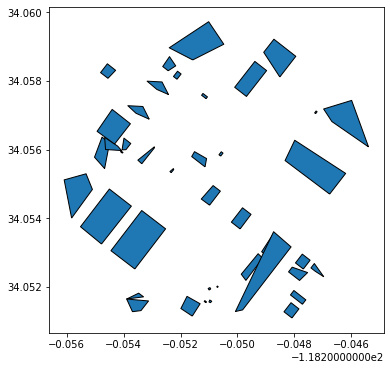

In [6]:
gdf.plot(figsize=(6, 6),edgecolor='black')

In [7]:
'''
    Building TARGET.
'''
# Random Target
# Target = gdf.sample(n=1)

# Specific Target
Target = gdf.loc[gdf['name'] == 'Bank of America Plaza']


<AxesSubplot:>

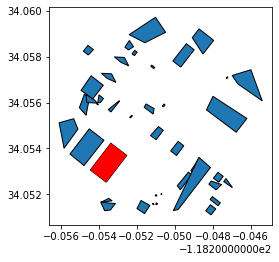

In [8]:
base = gdf.plot(edgecolor='black')
Target.plot(ax=base, color='red')

In [13]:
gdf = gp.read_file("obstacles400.gpkg")

In [14]:
'''
    Building query points, all of them being at random locations.
    x = Longitude
    y = Latitude
'''
minx, miny, maxx, maxy = gdf.total_bounds

n_queryPoints = 60
coords = []
for _ in range(n_queryPoints//4):
    coords.append((minx,round( (maxy - miny)*random() + miny , 6 )))
for _ in range(n_queryPoints//4):
    coords.append((maxx,round( (maxy - miny)*random() + miny , 6 )))
for _ in range(n_queryPoints//4):
    coords.append( (round( (maxx - minx)*random()+minx , 6 ) ,miny) )
for _ in range(n_queryPoints//4):
    coords.append( (round( (maxx - minx)*random()+minx , 6 ) ,maxy) )

coords = np.asarray(coords)
lats = coords[:,1:].flatten()
longs = coords[:,:1].flatten()


In [15]:
qpDataframe = pd.DataFrame({
    'id': list(range(0,n_queryPoints)),
    'x': longs.tolist(),
    'y': lats.tolist(),
})

qpGdf = gp.GeoDataFrame(
    qpDataframe, geometry=gp.points_from_xy(qpDataframe.x, qpDataframe.y))



    id           x          y                     geometry
0    0 -118.256557  34.051514  POINT (-118.25656 34.05151)
1    1 -118.256557  34.058490  POINT (-118.25656 34.05849)
2    2 -118.256557  34.056371  POINT (-118.25656 34.05637)
3    3 -118.256557  34.055507  POINT (-118.25656 34.05551)
4    4 -118.256557  34.056159  POINT (-118.25656 34.05616)
5    5 -118.256557  34.058550  POINT (-118.25656 34.05855)
6    6 -118.256557  34.053886  POINT (-118.25656 34.05389)
7    7 -118.256557  34.052505  POINT (-118.25656 34.05250)
8    8 -118.256557  34.058080  POINT (-118.25656 34.05808)
9    9 -118.256557  34.056457  POINT (-118.25656 34.05646)
10  10 -118.256557  34.058057  POINT (-118.25656 34.05806)
11  11 -118.256557  34.058277  POINT (-118.25656 34.05828)
12  12 -118.256557  34.053556  POINT (-118.25656 34.05356)
13  13 -118.256557  34.051691  POINT (-118.25656 34.05169)
14  14 -118.256557  34.055966  POINT (-118.25656 34.05597)
15  15 -118.245045  34.054907  POINT (-118.24505 34.0549

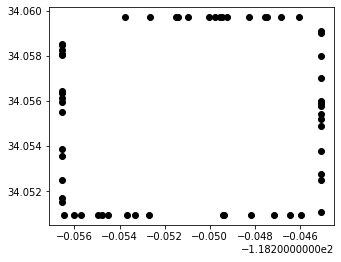

In [16]:
qpGdf.plot( color="black")
print(qpGdf)

In [185]:
# '''
#     Extracting to csv
# '''
# qpGdf.to_csv('querypoints.csv')
# Target.to_csv('target.csv')
# gdf.to_csv('obstacles.csv')

In [19]:
'''
    Extracting to files
'''
qpGdf.to_file('querypoints400_60a.gpkg', driver="GPKG")


# Target.to_file('target')

In [5]:

gdf_save = gdf.applymap(lambda x: str(x) if isinstance(x, list) else x)
gdf_save.drop(labels="nodes", axis=1).to_file("obstacles.gpkg", driver="GPKG")